<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [1]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

     |████████████████████████████████| 112kB 7.6MB/s 
     |████████████████████████████████| 9.5MB 23.0MB/s 
     |████████████████████████████████| 634kB 48.1MB/s 
     |████████████████████████████████| 11.6MB 42.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 71kB 5.3MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 184kB 44.5MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639234 sha256=60a251b40cf5a36d386bed73b2ee26994e1d0c233315795f112321a240eb8c5b
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
     |████████████████████████████████| 5.7MB 7.2MB/s 
     |████████████████████████████████| 22.3MB 1.3MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... do

In [1]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np


## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



В качестве данных с дневной частотой было приняторешение выгрузить данные из внутрикорпоративной CRM-системы salesforce с работы. После создания в системе соотетствующих репортов я подгрузил данные в Tableau, чтобы в пару шагов представить их частоту в требуемом по условию формате. Я решил взять количество завершённых ордеров на выполнение инженерами работы в России за последние два года.  

Также я решил использовать данные с Kaggle ([набор данных по моделированию цен на электричество в городе Виктория, находящемся в Австралии](https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia)) и в качестве данных с месячной частотой взял данные по средней максимальной температуре по ходу месяца. Такой признак обуславливается достаточно хорошей сезонностью и, вероятно, значительно влияет на потребление электричества в силу использования кондиционеров в наиболее жаркие месяца, поэтом прогнозирование такого временного ряда может поспособствовать увеличению прибыли энергетической компании.

 

Ссылки на данные (экспортируемые из Tableau и взятые с Kaggle) представлены [в Яндекс-диске](https://disk.yandex.ru/d/LMe4xq5pRGsmtQ)

Я долго пытался понять как через команды bash и другие библиотеки настроить скачивание с Яндекс-диска во временную память Google Colab, но не нашёл подходящего работающего нормально способа и поэтому вручную подгрузил эти данные. Надеюсь, это не повлечёт за собой никакого штрафа...

In [2]:
# считаем файлы
ts1 = pd.read_csv('daily data (completed WO Russia).csv', sep=',', encoding='utf-8-sig') #данные о выполненных ворк ордерах
ts2 = pd.read_csv('complete_dataset.csv', sep=',', encoding='utf-8-sig') #данные о температуре в Австралии

In [4]:
ts1 = ts1.fillna(0)
ts1.head()

,Date,Number of Work Orders,Weekday
0,01/06/2019,24.0,5
1,02/06/2019,15.0,6
2,03/06/2019,15.0,0
3,04/06/2019,17.0,1
4,05/06/2019,10.0,2


Проверим, что в данных поровну каждого из дней недели, это пригодится нам для проверки гипотезы о наличии сезонности в данных.

In [5]:
from datetime import datetime
ts1['Weekday'] = 0
for i in range(len(ts1)):
  ts1['Weekday'][i] = datetime.strptime(ts1['Date'][i], '%d/%m/%Y').weekday()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [6]:
ts1['Weekday'].value_counts()

6    105
5    105
0    105
4    104
3    104
2    104
1    104
Name: Weekday, dtype: int64

In [6]:
ts1 = ts1[3:]
ts1['Weekday'].value_counts()

6    104
5    104
4    104
3    104
2    104
1    104
0    104
Name: Weekday, dtype: int64

In [7]:
ts2 = ts2[['date', 'max_temperature']]
ts2['date'] = ts2['date'].astype(str).str.slice(stop=7)
ts2 = ts2.groupby(['date']).mean().reset_index()
ts2.head()

,date,max_temperature
0,2015-01,25.851613
1,2015-02,26.371429
2,2015-03,22.722581
3,2015-04,19.236667
4,2015-05,17.132258


In [8]:
test_size1 = 31+30+31
test_size2 = 12*2

In [9]:
ts1_train = ts1[:-test_size1]
ts1_test = ts1[-test_size1:]

ts2_train = ts2[:-test_size2]
ts2_test = ts2[-test_size2:]

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

In [11]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Uninstalling matplotlib-3.3.4:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.4-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.4
     |████████████████████████████████| 13.1MB 233kB/s 
ERROR: prophet 1.0.1 has requirement cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.
ERROR: orbit-ml 1.0.13 has requirement matplotlib==3.3.4, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentatio

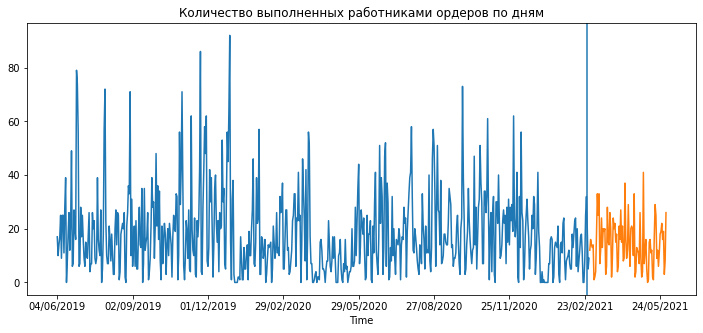

In [12]:
# отрисуем временные ряды для данных по дням
plt.figure(figsize=(12, 5))
plt.plot(ts1_train['Date'], ts1_train[' Number of Work Orders'])
plt.plot(ts1_test['Date'], ts1_test[' Number of Work Orders'])
plt.axvline(x=ts1['Date'][len(ts1)-test_size1])
plt.xlabel('Time')
plt.xticks(ts1['Date'][::90])
plt.title('Количество выполненных работниками ордеров по дням')
plt.show()

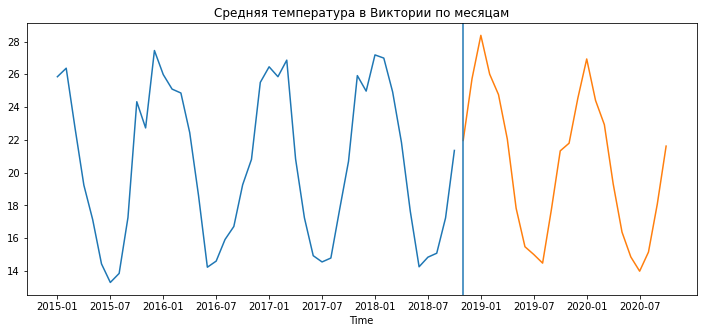

In [13]:
# отрисуем временные ряды для данных по месяцам
plt.figure(figsize=(12, 5))
plt.plot(ts2_train['date'], ts2_train['max_temperature'])
plt.plot(ts2_test['date'], ts2_test['max_temperature'])
plt.axvline(x=ts2['date'][len(ts2)-test_size2])
plt.xlabel('Time')
plt.title('Средняя температура в Виктории по месяцам')
plt.xticks(ts2['date'][::6])
plt.show()

Для анализа автокорреляционной функции сформулируем две гипотезы: количество завершённых Work Order'ов зависит от дня недели (в понедельник и вторник инженеры более продуктивны, в субботу и воскресенье большинство отдыхает), средняя ежедневная максимальная температура по ходу месяца повторяется каждые 12 месяцев.

In [14]:
# посчитаем коэффициент автокорреляции
def autocorr_coef(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))
autocorr_coef(ts1[' Number of Work Orders'], t=7)

array([[1.       , 0.3392942],
       [0.3392942, 1.       ]])

In [15]:
autocorr_coef(ts2['max_temperature'], t=12)

array([[1.        , 0.93941879],
       [0.93941879, 1.        ]])

In [16]:
# посчитайте и нарисуйте график автокорреляционной функции
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

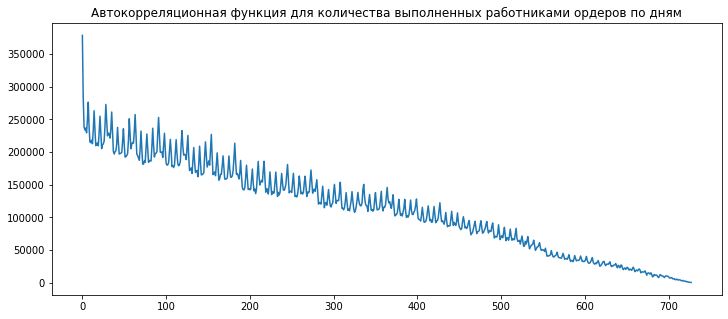

In [17]:
# отрисуем временные ряды для данных по дням
plt.figure(figsize=(12, 5))
plt.plot(autocorr(ts1[' Number of Work Orders']))
plt.title('Автокорреляционная функция для количества выполненных работниками ордеров по дням')
plt.show()

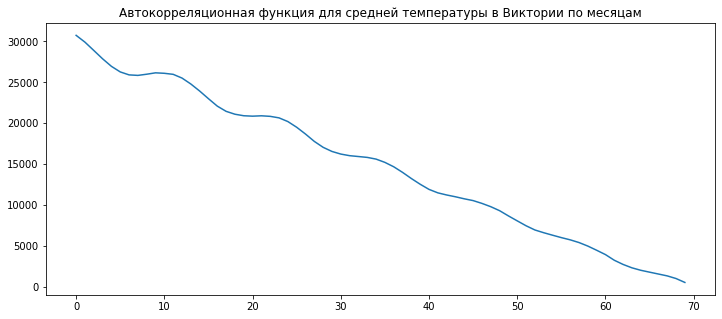

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(autocorr(ts2['max_temperature']))
plt.title('Автокорреляционная функция для средней температуры в Виктории по месяцам')
plt.show()

После того, как воспользовался кодом [отсюда](https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation), не совсем понял что отражают графики выше, хоть вроде бы и изучал случайные процессы...

Попробуем воспользоваться функцией из библиотеки statmodels

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

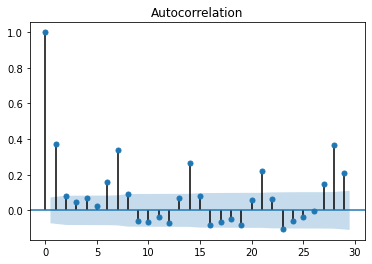

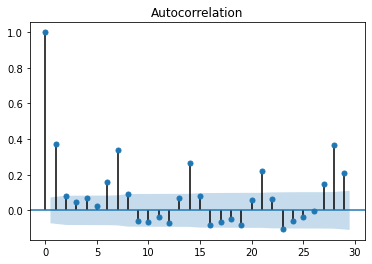

In [20]:
plot_acf(ts1[' Number of Work Orders'])

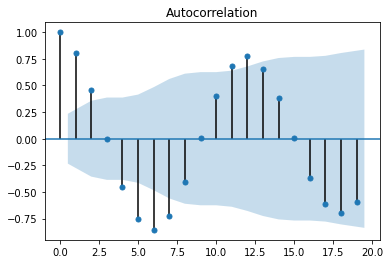

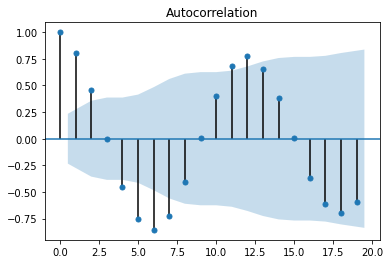

In [21]:
plot_acf(ts2['max_temperature'])

Видим, что в целом моя гипотеза рабочая и не отвергается. Наибольшее значение автокорреляционнной функции для данных с дневной частотой достигается при лаге=7 (хотя при этом коэффициент автокорреляции весьма мал), для данных с месячной частотой - при лаге=12.

In [22]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

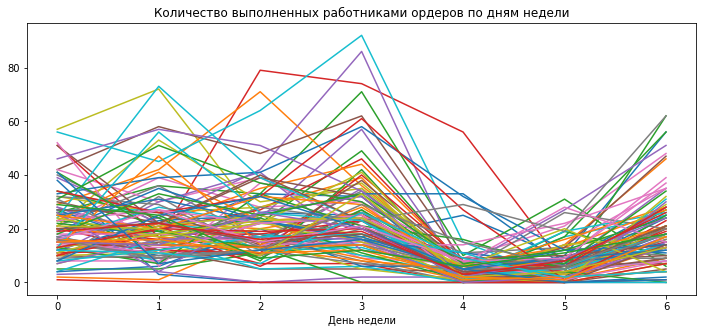

In [23]:
seasons1 = np.array(ts1[' Number of Work Orders']).reshape((-1, 7))
# отрисуем недельные отрезки для данных по дням
plt.figure(figsize=(12, 5))
plt.plot(seasons1.T)
plt.xlabel('День недели')
plt.title('Количество выполненных работниками ордеров по дням недели')
plt.show()

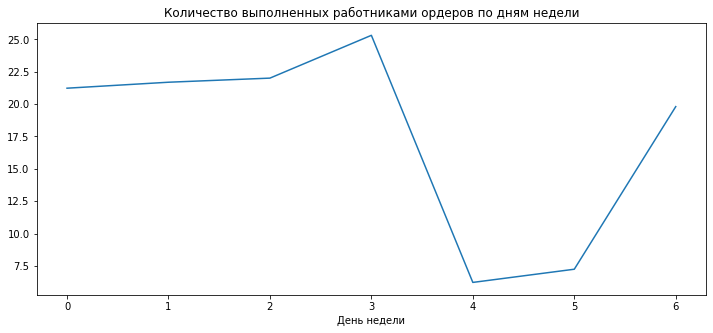

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(np.mean(seasons1, axis=0))
plt.xlabel('День недели')
plt.title('Количество выполненных работниками ордеров по дням недели')
plt.show()

Видим, что среднее значение по дням недели в пятницу и субботу действительно на порядок ниже, чем в остальные дни, поэтому гипотеза о сезонности по дням недели имеет место.

In [25]:
ts2['date'].values

array(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10'], dtype=object)

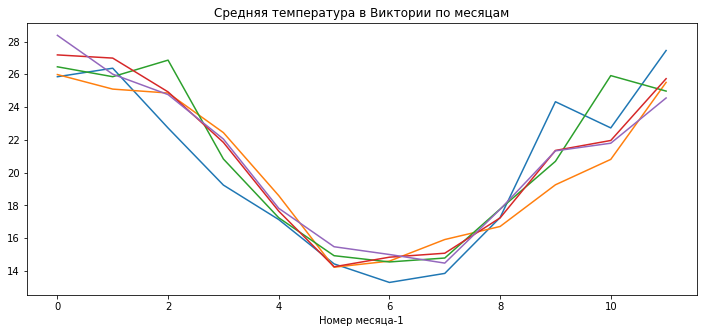

In [26]:
seasons2 = np.array(ts2['max_temperature'][:-10]).reshape((-1, 12))
# отрисуем недельные отрезки для данных по дням
plt.figure(figsize=(12, 5))
plt.plot(seasons2.T)
plt.xlabel('Номер месяца-1')
plt.title('Средняя температура в Виктории по месяцам')
plt.show()

Для периода из 5 лет с 2015 по 2019 год средняя максимальная температура отчётливо поддаётся сезонности, отражая зимние июнь-август и летние декабрь-февраль на южном полушарии Земли.

![image](https://sun9-19.userapi.com/impg/w3fhNMCuvrok0OSRkTA01sN64h2LM289X7ILeg/FX5T6aIAIYU.jpg?size=301x128&quality=96&sign=4164e106c5dfb86acb788542c65eda13&type=album)

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [27]:
train_ets = ts2_train.copy()
train_ets.index = pd.PeriodIndex(ts2_train['date'], freq='M')

In [28]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy='last')
forecaster.fit(ts2_train['max_temperature'])
ts2_pred = forecaster.predict(fh=np.arange(len(ts2_test)) + 1)

In [29]:
ts2_pred

46    21.351613
47    21.351613
48    21.351613
49    21.351613
50    21.351613
51    21.351613
52    21.351613
53    21.351613
54    21.351613
55    21.351613
56    21.351613
57    21.351613
58    21.351613
59    21.351613
60    21.351613
61    21.351613
62    21.351613
63    21.351613
64    21.351613
65    21.351613
66    21.351613
67    21.351613
68    21.351613
69    21.351613
dtype: float64

In [30]:
# посчитайте метрики на test
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ts2_test['max_temperature'], ts2_pred)

3.8138197423945464

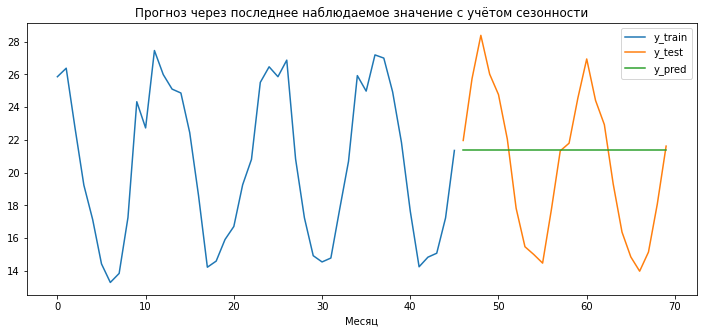

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(ts2_train['max_temperature'], label="y_train")
plt.plot(ts2_test['max_temperature'], label="y_test")
plt.plot(ts2_pred, label="y_pred")
plt.legend()
plt.xlabel('Месяц')
plt.title('Прогноз через последнее наблюдаемое значение с учётом сезонности')
plt.show()

In [32]:
forecaster = NaiveForecaster(strategy='last', sp=12)
forecaster.fit(ts2_train['max_temperature'])
ts2_pred = forecaster.predict(fh=np.arange(len(ts2_test)) + 1)
mean_absolute_error(ts2_test['max_temperature'], ts2_pred)

1.0747676872009455

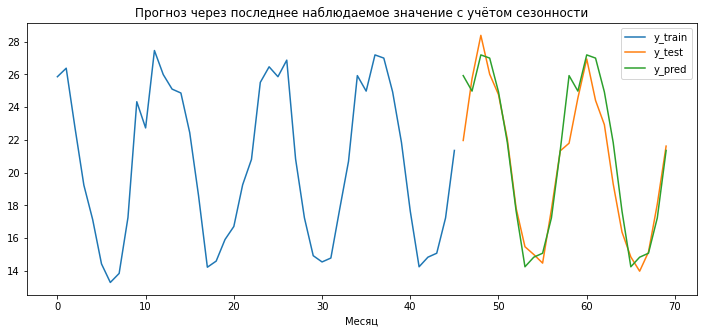

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(ts2_train['max_temperature'], label="y_train")
plt.plot(ts2_test['max_temperature'], label="y_test")
plt.plot(ts2_pred, label="y_pred")
plt.legend()
plt.xlabel('Месяц')
plt.title('Прогноз через последнее наблюдаемое значение с учётом сезонности')
plt.show()

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* [SARIMA](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.ARIMA.html?highlight=arima)(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* [Алгоритм Хиндмана-Хандакара](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html) подбора SARIMA (`AutoARIMA` в `sktime`)

In [34]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

# ваш код обучения моделей здесь
ar = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12), suppress_warnings=True)
ar.fit(ts2_train['max_temperature'])
ts2_pred = ar.predict(fh=np.arange(len(ts2_test)) + 1)

In [35]:
# посчитайте метрики на test
mean_absolute_error(ts2_test['max_temperature'], ts2_pred)

1.2559434375604992

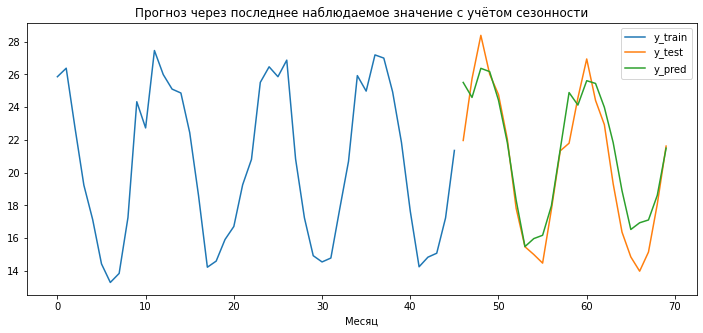

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(ts2_train['max_temperature'], label="y_train")
plt.plot(ts2_test['max_temperature'], label="y_test")
plt.plot(ts2_pred, label="y_pred")
plt.legend()
plt.xlabel('Месяц')
plt.title('Прогноз через модель ARIMA')
plt.show()

In [37]:
auto_ar = AutoARIMA(start_p=3, max_p=24, sp=12, suppress_warnings=True, maxiter=200)
auto_ar.fit(ts2_train['max_temperature'])
ts2_pred = ar.predict(fh=np.arange(len(ts2_test)) + 1)
mean_absolute_error(ts2_test['max_temperature'], ts2_pred)

1.2559434375604992

Видим, что результаты работы AutoARIMA & ARIMA выдали одинаковые результаты, поскольку, видимо, истинное значение сезонности действительно равно 12. 

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели [LGT](https://orbit-ml.readthedocs.io/en/latest/tutorials/lgt.html) и [DLT](https://orbit-ml.readthedocs.io/en/latest/tutorials/dlt.html)

In [46]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull

# ваш код обучения моделей здесь
lgt = LGTFull(response_col='max_temperature',
    date_col='date',
    seasonality=12,
    seed=100)
lgt.fit(df=ts2_train)
ts2_pred = lgt.predict(df=ts2_test)
ts2_pred.tail(5)

,date,prediction_5,prediction,prediction_95
19,2020-06,-2.019837,19.460091,69.974234
20,2020-07,-0.635178,18.950205,68.366183
21,2020-08,-0.333737,18.124699,67.083365
22,2020-09,0.437030,19.329300,66.694027
23,2020-10,1.026138,18.451925,70.576813


In [47]:
# посчитайте метрики на test
mean_absolute_error(ts2_test['max_temperature'], ts2_pred['prediction'])

2.924983602963239

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

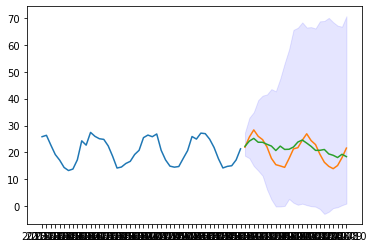

In [48]:
fig, ax = plt.subplots()
ax.plot(ts2_train['date'], ts2_train['max_temperature'])
ax.plot(ts2_test['date'], ts2_test['max_temperature'])
ax.plot(ts2_pred['date'], ts2_pred['prediction'])
ax.fill_between(ts2_pred['date'], ts2_pred['prediction_5'], ts2_pred['prediction_95'], color='b', alpha=.1)

In [63]:
dlt = DLTFull(response_col='max_temperature',
    date_col='date',
    seasonality=12,
    seed=100)
dlt.fit(df=ts2_train)
ts2_pred = dlt.predict(df=ts2_test)
ts2_pred.tail(5)

,date,prediction_5,prediction,prediction_95
19,2020-06,-28.128586,34.496048,87.405450
20,2020-07,-28.689241,35.529399,91.537880
21,2020-08,-24.225774,35.032013,97.701822
22,2020-09,-24.432863,35.749088,101.190121
23,2020-10,-26.303739,35.795423,105.248199


In [64]:
mean_absolute_error(ts2_test['max_temperature'], ts2_pred['prediction'])

13.510561343789435

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

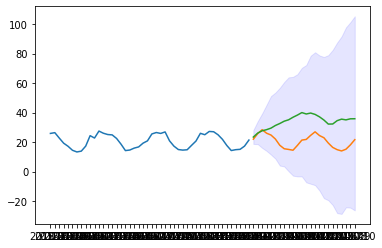

In [67]:
fig, ax = plt.subplots()
ax.plot(ts2_train['date'], ts2_train['max_temperature'])
ax.plot(ts2_test['date'], ts2_test['max_temperature'])
ax.plot(ts2_pred['date'], ts2_pred['prediction'])
ax.fill_between(ts2_pred['date'], ts2_pred['prediction_5'], ts2_pred['prediction_95'], color='b', alpha=.1)

Видим, что обе модели из библиотеки orbit выдали сомнительные результаты, ни коим образом не отражающие адекватные возможные значения прогнозов погоды в городе Виктория. Попробуем разобраться, почему так

### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* [ETS(AAA)](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.exp_smoothing.ExponentialSmoothing.html?highlight=ExponentialSmoothing%20) (`ExponentialSmoothing` в `sktime`)
* [ETS с автоматическим выбором по AIC](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.ets.AutoETS.html?highlight=AutoETS%20) (`AutoETS` в `sktime`)

In [52]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь
forecaster = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
forecaster.fit(ts2_train['max_temperature'])
ts2_pred = forecaster.predict(fh=np.arange(len(ts2_test)) + 1)

In [53]:
# посчитайте метрики на test
mean_absolute_error(ts2_test['max_temperature'], ts2_pred)

1.0754030128291754

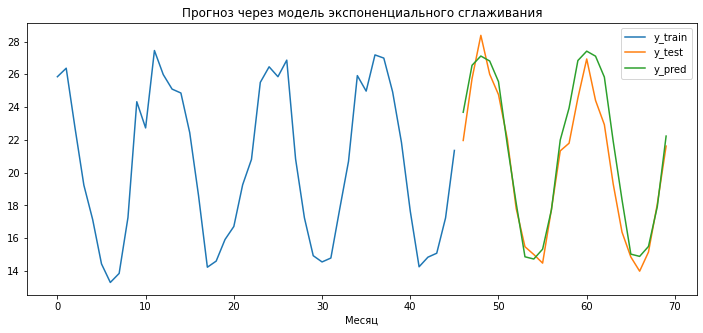

In [54]:
plt.figure(figsize=(12, 5))
plt.plot(ts2_train['max_temperature'], label="y_train")
plt.plot(ts2_test['max_temperature'], label="y_test")
plt.plot(ts2_pred, label="y_pred")
plt.legend()
plt.xlabel('Месяц')
plt.title('Прогноз через модель экспоненциального сглаживания')
plt.show()

In [69]:
forecaster = AutoETS(trend='add', seasonal='add', sp=12)
forecaster.fit(ts2_train['max_temperature'])
ts2_pred = forecaster.predict(fh=np.arange(len(ts2_test)) + 1)
mean_absolute_error(ts2_test['max_temperature'], ts2_pred)

1.0393728565085547

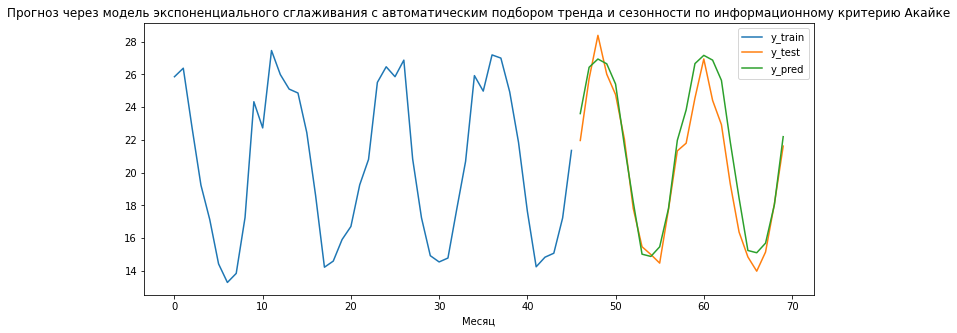

In [70]:
plt.figure(figsize=(12, 5))
plt.plot(ts2_train['max_temperature'], label="y_train")
plt.plot(ts2_test['max_temperature'], label="y_test")
plt.plot(ts2_pred, label="y_pred")
plt.legend()
plt.xlabel('Месяц')
plt.title('Прогноз через модель экспоненциального сглаживания с автоматическим подбором тренда и сезонности по информационному критерию Акайке')
plt.show()

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

AutoETS обладает наименьшей средней абсолютной ошибкой среди всех рассмотренных моделей. Попробуем добавить для неё доверительные интервалы:

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

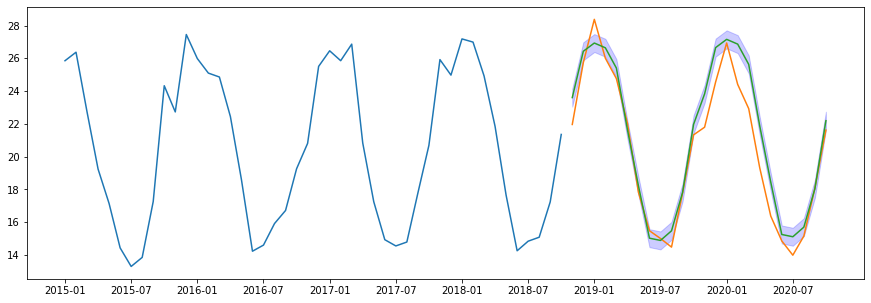

In [83]:
# нарисуйте предсказания
ci = 2.58 * np.std(ts2_pred)/np.mean(ts2_pred) #вычислим 99% доверительные интервалы
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ts2_train['date'], ts2_train['max_temperature'])
ax.plot(ts2_test['date'], ts2_test['max_temperature'])
ax.plot(ts2_test['date'], ts2_pred)
ax.fill_between(ts2_test['date'], ts2_pred-ci, ts2_pred+ci, color='b', alpha=.2)
plt.setp(ax, xticks=ts2['date'][::6])

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
train_ets = ts2_train.copy()
train_ets.index = pd.PeriodIndex(ts2_train['date'], freq='M')

In [86]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy='last')
forecaster.fit(ts1_train[' Number of Work Orders'])
ts1_pred = forecaster.predict(fh=np.arange(len(ts1_test)) + 1)

In [87]:
ts1_pred

639    9.0
640    9.0
641    9.0
642    9.0
643    9.0
      ... 
726    9.0
727    9.0
728    9.0
729    9.0
730    9.0
Length: 92, dtype: float64

In [88]:
# посчитайте метрики на test
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ts1_test[' Number of Work Orders'], ts1_pred)

8.326086956521738

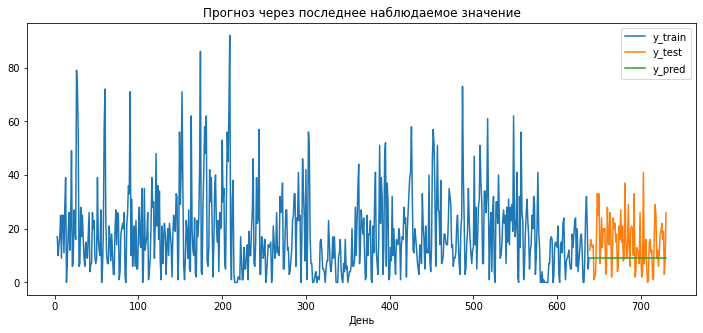

In [89]:
plt.figure(figsize=(12, 5))
plt.plot(ts1_train[' Number of Work Orders'], label="y_train")
plt.plot(ts1_test[' Number of Work Orders'], label="y_test")
plt.plot(ts1_pred, label="y_pred")
plt.legend()
plt.xlabel('День')
plt.title('Прогноз через последнее наблюдаемое значение')
plt.show()

In [90]:
forecaster = NaiveForecaster(strategy='last', sp=7)
forecaster.fit(ts1_train[' Number of Work Orders'])
ts1_pred = forecaster.predict(fh=np.arange(len(ts1_test)) + 1)
mean_absolute_error(ts1_test[' Number of Work Orders'], ts1_pred)

9.641304347826088

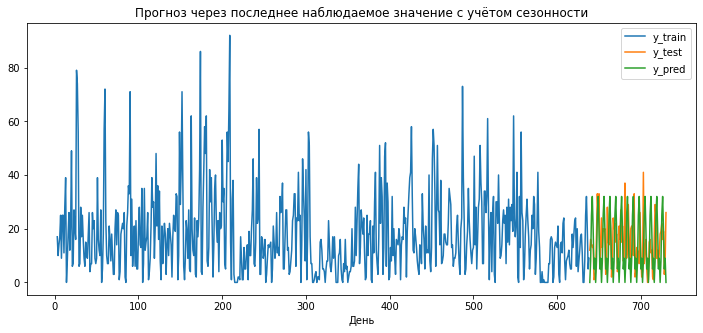

In [91]:
plt.figure(figsize=(12, 5))
plt.plot(ts1_train[' Number of Work Orders'], label="y_train")
plt.plot(ts1_test[' Number of Work Orders'], label="y_test")
plt.plot(ts1_pred, label="y_pred")
plt.legend()
plt.xlabel('День')
plt.title('Прогноз через последнее наблюдаемое значение с учётом сезонности')
plt.show()

Видим, что несмотря на то, что для 7-дневных интервалов мы получили наибольшее значение автокорреляционной функции, данным с дневной частотой не совсем свойственна сезонность

### [KTR](https://orbit-ml.readthedocs.io/en/latest/tutorials/ktrlite.html) из orbit (1 балл).



In [112]:
contains_duplicates = any(ts1_train['Date'].values.tolist().count(element) > 1 for element in ts1_train['Date'].values.tolist())
contains_duplicates

False

In [140]:
ts1_train_ktr = pd.concat([pd.to_datetime(ts1_train['Date'], format='%d/%m/%Y'), ts1_train[' Number of Work Orders']], axis=1)
ts1_test_ktr = pd.concat([pd.to_datetime(ts1_test['Date'], format='%d/%m/%Y'), ts1_test[' Number of Work Orders']], axis=1)

In [173]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь
ktrlite = KTRLiteMAP(
    response_col=' Number of Work Orders',
    date_col='Date',
    # seasonality
    seasonality=[7, 365],
    level_knot_scale=.1,
    span_level=.05)
ktrlite.fit(ts1_train_ktr)
ts1_pred = ktrlite.predict(df=ts1_test_ktr, decompose=True)
ts1_pred.head()

,Date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365_5,seasonality_365,seasonality_365_95
0,2021-03-01,-7.049527,16.793650,40.943625,17.904663,17.991751,18.080630,2.052705,2.052705,2.052705,-3.250836,-3.250836,-3.250836
1,2021-03-02,-5.116354,19.652202,44.786456,17.897403,17.991749,18.088034,4.934240,4.934240,4.934240,-3.273818,-3.273818,-3.273818
2,2021-03-03,-7.676556,16.152620,40.343129,17.890143,17.991747,18.095438,1.456212,1.456212,1.456212,-3.295372,-3.295372,-3.295372
3,2021-03-04,-3.881855,20.506439,44.532657,17.882883,17.991744,18.102842,5.830151,5.830151,5.830151,-3.315492,-3.315492,-3.315492
4,2021-03-05,-5.119544,19.132987,43.263390,17.875623,17.991742,18.110246,4.475379,4.475379,4.475379,-3.334172,-3.334172,-3.334172


In [174]:
# посчитайте метрики на test
mean_absolute_error(ts1_test[' Number of Work Orders'], ts1_pred['prediction'])

5.890805460561933

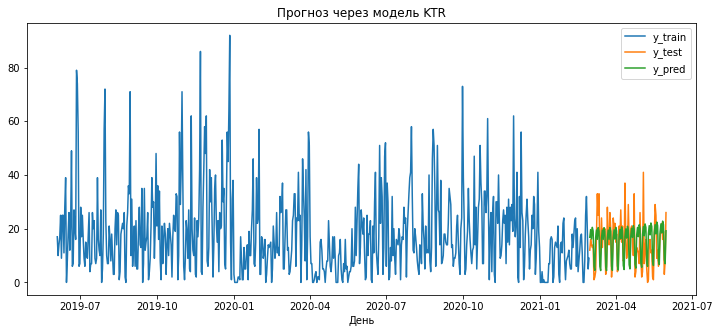

In [154]:
plt.figure(figsize=(12, 5))
plt.plot(ts1_train_ktr['Date'], ts1_train_ktr[' Number of Work Orders'], label="y_train")
plt.plot(ts1_test_ktr['Date'], ts1_test_ktr[' Number of Work Orders'], label="y_test")
plt.plot(ts1_pred['Date'], ts1_pred['prediction'], label="y_pred")
plt.legend()
plt.xlabel('День')
plt.title('Прогноз через модель KTR')
plt.show()

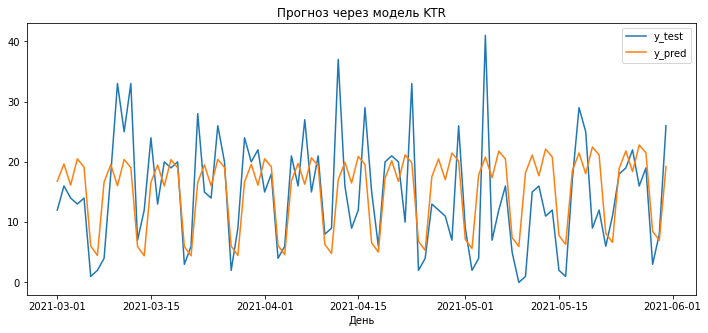

In [175]:
plt.figure(figsize=(12, 5))
plt.plot(ts1_test_ktr['Date'], ts1_test_ktr[' Number of Work Orders'], label="y_test")
plt.plot(ts1_pred['Date'], ts1_pred['prediction'], label="y_pred")
plt.legend()
plt.xlabel('День')
plt.title('Прогноз через модель KTR')
plt.show()

### Phophet (1 балл).



In [165]:
ts1_train_prophet = ts1_train_ktr.rename(columns={'Date': 'ds', ' Number of Work Orders': 'y'})
ts1_test_prophet = ts1_test_ktr.rename(columns={'Date': 'ds', ' Number of Work Orders': 'y'})

In [178]:
from prophet import Prophet

# ваш код обучения моделей здесь
m = Prophet()
m.fit(ts1_train_prophet)
ts1_pred = m.predict(ts1_test_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [167]:
# посчитайте метрики на test
mean_absolute_error(ts1_test_prophet['y'], ts1_pred['yhat'])

5.731162388232383

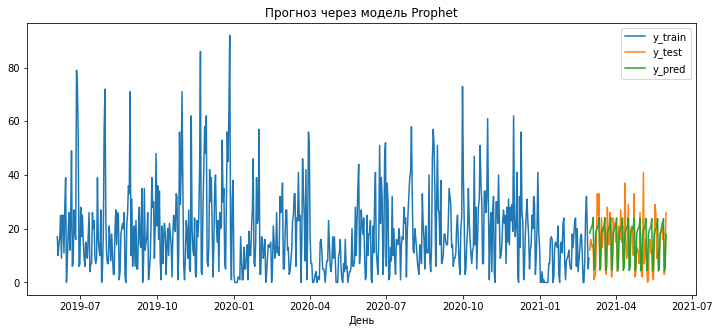

In [170]:
plt.figure(figsize=(12, 5))
plt.plot(ts1_train_prophet['ds'], ts1_train_prophet['y'], label="y_train")
plt.plot(ts1_test_prophet['ds'], ts1_test_prophet['y'], label="y_test")
plt.plot(ts1_pred['ds'], ts1_pred['yhat'], label="y_pred")
plt.legend()
plt.xlabel('День')
plt.title('Прогноз через модель Prophet')
plt.show()

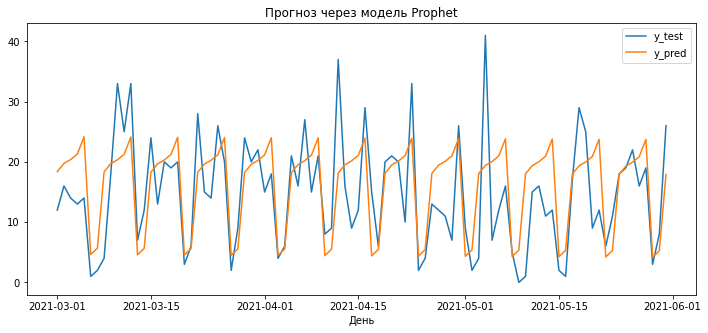

In [171]:
plt.figure(figsize=(12, 5))
plt.plot(ts1_test_prophet['ds'], ts1_test_prophet['y'], label="y_test")
plt.plot(ts1_pred['ds'], ts1_pred['yhat'], label="y_pred")
plt.legend()
plt.xlabel('День')
plt.title('Прогноз через модель Prophet')
plt.show()

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

Наилучшее значение метрики МАЕ оказалось на модели из библиотеки Prophet, попробуем отрисовать её.

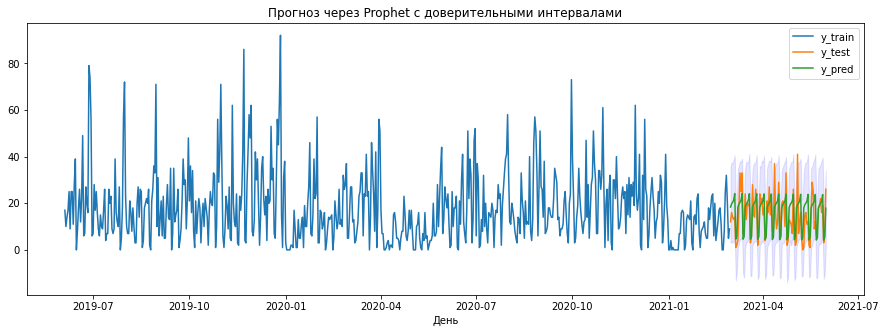

In [181]:
# нарисуйте предсказания
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ts1_train_prophet['ds'], ts1_train_prophet['y'], label="y_train")
ax.plot(ts1_test_prophet['ds'], ts1_test_prophet['y'], label="y_test")
ax.plot(ts1_pred['ds'], ts1_pred['yhat'], label="y_pred")
ax.legend()
ax.set_xlabel('День')
ax.set_title('Прогноз через Prophet с доверительными интервалами')
ax.fill_between(ts1_pred['ds'], ts1_pred['yhat_lower'], ts1_pred['yhat_upper'], color='b', alpha=.1)

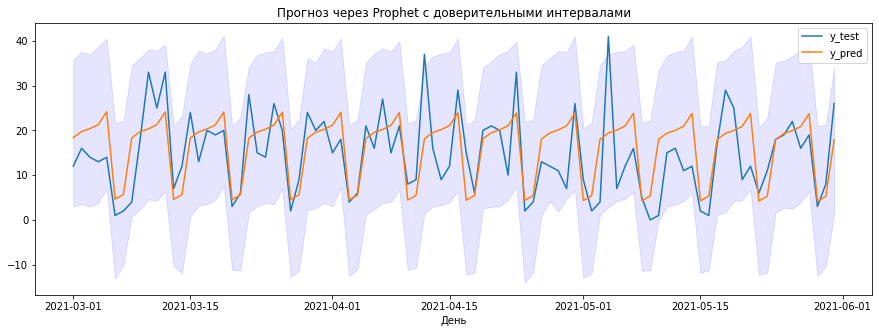

In [182]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ts1_test_prophet['ds'], ts1_test_prophet['y'], label="y_test")
ax.plot(ts1_pred['ds'], ts1_pred['yhat'], label="y_pred")
ax.legend()
ax.set_xlabel('День')
ax.set_title('Прогноз через Prophet с доверительными интервалами')
ax.fill_between(ts1_pred['ds'], ts1_pred['yhat_lower'], ts1_pred['yhat_upper'], color='b', alpha=.1)

Видим, что и модель из библиотеки Orbit, и модель из библиотеки Prophet справились с задачей прогнозирования количества завершённых в России ворк ордеров даже лучше выдвиженных мной гипотез, выявив некоторые месячные, недельные тренды и спрогнозировав значения с минимальной ошибкой.

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытай свою модель для месячного ряда в [STAN](https://colab.research.google.com/drive/1QqZDbijR5__Kf-qV7Sfq05_ng7x66jrz?usp=sharing).

Сравните качество прогнозов с наивной сезонной на тестовой выборке с помощью MAE. 



In [10]:
!pip install pystan

In [11]:
import pystan

In [54]:
# ваш код модели на STAN и её обучения моделей здесь
model_code = """
data {
  int<lower=0> n;         // number of observations
  vector[n] y;            // time series data
  vector[n] x;            // predictor
}
parameters {
  // equation parameters
  real<lower=0, upper=0.5> alpha;   // alpha
  real<lower=0, upper=2> beta;  // beta
  real<lower=0, upper=0.5> gamma;    // gamma
  real<lower=0, upper=0.5> theta;    // theta
  real<lower=0, upper=10> xi;      // xi
  real k;                          // k
  real<lower=0> sigma;             // sigma

  // initial values
  real linit;        // linit
  real binit;        // binit
  vector[12] sinit;  // sinit
}
transformed parameters {
  vector[n+1] l;  // l
  vector[n+1] b;  // b
  vector[n+12] s;  // s
  vector[n] r;     // r
  vector[n] yhat;  // E(y_t | F_{t-1})

  // initial observations
  l[1] = linit;      // l
  b[1]=  binit;      // b
  for (t in 1:12) { // s
    s[t] = sinit[t];
  }          

  // update equations
  for (t in 1:n) {
    
    int tp; 
    int ts;

    tp = t + 1;
    ts = t + 12;

    r[t] = k * x[t];
    b[tp] = (1 - beta) * theta * b[tp-1] + beta * (y[t] - l[tp-1] - s[ts-12] - r[t]);
    s[ts] = s[ts-12] + gamma * (y[t] - l[tp-1] - theta * b[tp-1] - s[ts-12] - r[t]);
    l[tp] = (1 - alpha) * (l[tp-1] + r[t] + theta * b[tp-1])  + alpha * (y[t] - s[ts-12]);
    yhat[t] = l[tp-1] + theta * b[tp-1] + s[ts-12] * xi + r[t];
  }
}

model {
  // prior for e-parameters
  alpha ~ uniform(0, 0.5);
  beta ~ uniform(0, 2);
  gamma ~ uniform(0, 0.5);
  theta ~ uniform(0, 0.5);
  xi ~ uniform(0, 10);
  sigma ~ normal(0, 10) T[0, ];  // T[a, b] or T[a, ] or T[, b] means truncated
  k ~ normal(0, 5);
  
  // prior for initial values
  linit ~ normal(0, 5);
  binit ~ normal(0, 5);
  sinit ~ normal(0, 5);   


  // likelihood for observed data
  for (t in 1:n) {
    y[t] ~ normal(yhat[t], sigma);
  }
}
"""

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_623900b00dd76c7e91e116e423909e26 NOW.


In [21]:
x = np.concatenate([np.ones(len(ts2_train)), np.zeros(len(ts2_test))])

In [55]:
ts2_data = {'n': len(ts2), 'y': ts2['max_temperature'].values, 'x': x}

post = model.sampling(ts2_data, chains=2, iter=5000, warmup=1000)

In [56]:
post


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_623900b00dd76c7e91e116e423909e26.
2 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=8000.

            mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha       0.16  3.4e-3   0.11 8.4e-3    0.07   0.14   0.24   0.42   1122    1.0
beta        0.66  8.8e-3   0.55   0.02    0.19    0.5   1.04   1.88   3974    1.0
gamma       0.15  3.1e-3   0.12 5.1e-3    0.06   0.13   0.22   0.43   1401    1.0
theta       0.18  3.1e-3   0.13 6.8e-3    0.07   0.16   0.28   0.46   1767    1.0
xi          0.89    0.01   0.17   0.34    0.84   0.91   0.97   1.16    126   1.01
k           0.04  2.3e-3   0.09  -0.13 -2.1e-3   0.04   0.09   0.24   1488    1.0
sigma       1.28  2.7e-3   0.14   1.04    1.18   1.27   1.36   1.58   2482    1.0
linit      17.49    0.11   2.18  12.97   16.17  17.62  18.88  21.71    420    1.0
binit       3.19    0.09   5.05  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68b4fb5c10>,
      dtype=object)

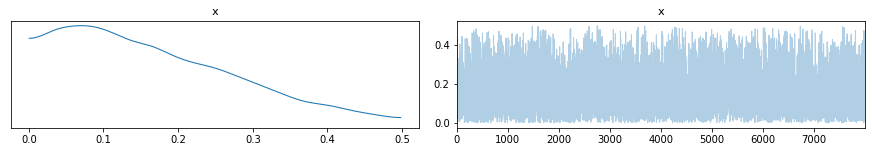

In [57]:
import arviz as az # visualizations for bayesian approach
az.plot_trace(post['alpha']) # визуально анализируем сходимость

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68b508a2d0>,
      dtype=object)

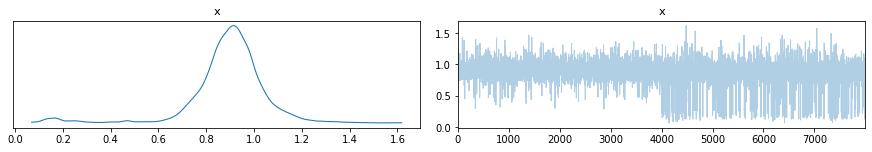

In [58]:
az.plot_trace(post['xi']) # визуально анализируем сходимость

In [65]:
y_hat = []
y_hat.append(np.median(post['l[48]']+ post['theta'] * post['b[48]'] + post['xi'] * post['s[35]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[49]']+ post['theta'] * post['b[49]'] + post['xi'] * post['s[36]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[50]']+ post['theta'] * post['b[50]'] + post['xi'] * post['s[37]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[51]']+ post['theta'] * post['b[51]'] + post['xi'] * post['s[38]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[52]']+ post['theta'] * post['b[52]'] + post['xi'] * post['s[39]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[53]']+ post['theta'] * post['b[53]'] + post['xi'] * post['s[40]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[54]']+ post['theta'] * post['b[54]'] + post['xi'] * post['s[41]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[55]']+ post['theta'] * post['b[55]'] + post['xi'] * post['s[42]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[56]']+ post['theta'] * post['b[56]'] + post['xi'] * post['s[43]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[57]']+ post['theta'] * post['b[57]'] + post['xi'] * post['s[44]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[58]']+ post['theta'] * post['b[58]'] + post['xi'] * post['s[45]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[59]']+ post['theta'] * post['b[59]'] + post['xi'] * post['s[46]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))

y_hat.append(np.median(post['l[60]']+ post['theta'] * post['b[60]'] + post['xi'] * post['s[47]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[61]']+ post['theta'] * post['b[61]'] + post['xi'] * post['s[48]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[62]']+ post['theta'] * post['b[62]'] + post['xi'] * post['s[49]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[63]']+ post['theta'] * post['b[63]'] + post['xi'] * post['s[50]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[64]']+ post['theta'] * post['b[64]'] + post['xi'] * post['s[51]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[65]']+ post['theta'] * post['b[65]'] + post['xi'] * post['s[52]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[66]']+ post['theta'] * post['b[66]'] + post['xi'] * post['s[53]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[67]']+ post['theta'] * post['b[67]'] + post['xi'] * post['s[54]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[68]']+ post['theta'] * post['b[68]'] + post['xi'] * post['s[55]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[69]']+ post['theta'] * post['b[69]'] + post['xi'] * post['s[56]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[70]']+ post['theta'] * post['b[70]'] + post['xi'] * post['s[57]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))
y_hat.append(np.median(post['l[71]']+ post['theta'] * post['b[71]'] + post['xi'] * post['s[58]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])))


In [ ]:
y_hat

In [66]:
# посчитайте метрики на test
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ts2_test['max_temperature'], y_hat)

0.4776543667791053

По сравнению с МАЕ=1.039 на лучшей модели из основной части задания (полученной через AutoETS) мы получили улучшение функционала ошибки более чем в 2 раза, что является, кажется, просто замечательным результатом. Ура!

In [67]:
y_pred = pd.concat([ts2_test['date'], pd.Series(y_hat, name='y_hat', index=ts2_test.index)], axis=1)

In [ ]:
y_pred

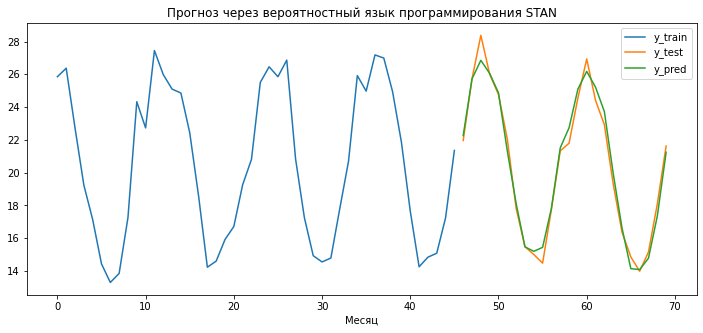

In [68]:
# нарисуйте предсказания
plt.figure(figsize=(12, 5))
plt.plot(ts2_train['max_temperature'], label='y_train')
plt.plot(ts2_test['max_temperature'], label="y_test")
plt.plot(y_pred['y_hat'], label="y_pred")
plt.legend()
plt.xlabel('Месяц')
plt.title('Прогноз через вероятностный язык программирования STAN')
plt.show()

Можем заметить, что модель STAN значительно ошиблась лишь на локальных экстремумах, что можно считать достаточно серьёзным достижением. В теории мы могли бы подгонять исходные параметры модели до идеальной подгонки, но кажется, что в этом нет значительной необходимости. Так, мы можем сделать вывод о достижении очень хорошей вероятностной модели, прогнозирующей погоду в Виктории. Может быть, мы можем прийти с этой моделью к синоптикам и стать руководителями прогнозов погоды :)